In [1]:
# Topic modelling demo using LDA and LDA-MALLET k-clusters
# Unsupervised learning: we do not need an annotated corpus (gold standard) to find topics
# Code modified from several sources

# Importing libraries, methods, etc
import os
import re
import numpy as np
from numpy import *
import pandas as pd
from pprint import pprint

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer

# Gensim libraries
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
from gensim.models import word2vec
from gensim.test.utils import common_texts
from gensim.sklearn_api import W2VTransformer

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# SpaCy
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\nepal\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
# Importing dataset
# Using pandas to open the dataset as a csv file
df = pd.read_csv('C:\\Users\\nepal\\Documents\\Syracuse teaching\\Extra Topics\\reddit_headlines_labels.csv') #'C:\\Users\\ri569\\Documents\\HSE\\hs_data_card_complete_jan20.csv')
# Filering by all observations with the label "0"
df = df.loc[df.label.isin(['0']) , :]
# Visualizing the filtered results
df.head()

,headline,label
0,Looking at buying a second Gen Cummins what sh...,0
1,Cummins swap |7.3L ---> 5.9L|,0
5,Tips for buying a 3rd gen mega cab,0
6,AEV Prospector,0
8,Need opinions on a truck,0


In [6]:
# Converting to list
data = df.headline.tolist()
# Preprocessing steps include a print statement to verify processing results
print(data[:3])

['Looking at buying a second Gen Cummins what should I look out for.', 'Cummins swap |7.3L ---> 5.9L|', 'Tips for buying a 3rd gen mega cab']


In [7]:
# Preprocessing using Gensim's "simple_preprocess"
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:2])


[['looking', 'at', 'buying', 'second', 'gen', 'cummins', 'what', 'should', 'look', 'out', 'for'], ['cummins', 'swap']]


In [37]:
# Building the bigram and trigram models using Gensim  
bigram = Phrases(data_words, min_count=5, threshold=100) # higher threshold represents fewer phrases.
trigram = Phrases(bigram[data_words], threshold=100) 

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)


C:\Users\nepal\Anaconda3\lib\site-packages\gensim\models\phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [38]:
# See trigram example. The output will show trigrams only if they are present
print(bigram_mod[data_words[10]])

['nd', 'to', 'th', 'gen', 'steering']


In [39]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
#from nltk.corpus import stopwords
stop_words = stopwords.words('english')
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [40]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

[['look', 'buy', 'second', 'gen', 'cummin', 'look'], ['cummin', 'swap']]


In [41]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency. "id2word" matches words with their IDs in the corpus
# "doc2bow" converts the corpus into a bag of words 
corpus = [id2word.doc2bow(text) for text in texts]

# View frequency tuples: first index is the word and second is the frequency for that word
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1)]]


In [42]:
# Printing the first token
id2word[0]

'buy'

In [43]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('buy', 1), ('cummin', 1), ('gen', 1), ('look', 2), ('second', 1)]]

In [44]:
# Build LDA model
# Avoiding future changes warning messages
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Parametize the model
# See details for parameters values: https://radimrehurek.com/gensim/models/ldamodel.html
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


In [45]:
# Print keyword for the topics created 
# the number besides the topic shows the probability score for that topic within the cluster
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.099*"cummin" + 0.061*"engine" + 0.040*"new" + 0.028*"inch" + 0.027*"ram" '
  '+ 0.025*"swap" + 0.024*"part" + 0.023*"tuner" + 0.014*"front" + '
  '0.014*"tell"'),
 (1,
  '0.078*"cummin" + 0.064*"swap" + 0.051*"delete" + 0.051*"look" + '
  '0.029*"conversion" + 0.027*"fuel" + 0.027*"anyone" + 0.026*"egr" + '
  '0.026*"buy" + 0.026*"pump"'),
 (2,
  '0.123*"cummin" + 0.066*"gen" + 0.038*"mile" + 0.038*"manual" + '
  '0.035*"dodge" + 0.034*"suggestion" + 0.033*"steer" + 0.021*"build" + '
  '0.021*"flywheel" + 0.021*"service"'),
 (3,
  '0.064*"gen" + 0.044*"ram" + 0.043*"cummin" + 0.025*"injector" + '
  '0.025*"source" + 0.023*"spd" + 0.023*"tuning" + 0.023*"mile" + 0.023*"rfe" '
  '+ 0.022*"dowel"'),
 (4,
  '0.060*"cummin" + 0.042*"start" + 0.041*"mile" + 0.024*"power" + '
  '0.024*"surge" + 0.022*"compound" + 0.022*"white" + 0.022*"smoke" + '
  '0.022*"clear" + 0.022*"second"')]


In [46]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # More than one model is needed for this measure. 
#The model with the lowest perplexity is generally considered the “best”.
# Compute Coherence Score. Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic.
# A set of statements or facts is said to be coherent, if they support each other. Thus, a coherent fact set can be interpreted in a context that covers all or most of the facts
# https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -4.665192300676946

Coherence Score:  0.5253161867387027


In [47]:
from __future__ import division

# Visualize the topics using pyLDAvis
# Save the visualization as an html file
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word,  mds='mmds')
pyLDAvis.display(vis, template_type='notebook') 
vis

pyLDAvis.save_html(vis,'LDA_viz.html')


In [48]:
## Creating LDA-Mallet model
# MALLET is an optimized type of LDA model
# Follow instructions to download MALLET from: http://mallet.cs.umass.edu/download.php
from gensim.models.wrappers import LdaMallet
os.environ.update({r'MALLET_HOME':r'C:\Users\nepal\Documents\NLP\mallet-2.0.8'})
mallet_path = r'C:\Users\nepal\Documents\NLP\mallet-2.0.8\bin\mallet'

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=id2word)

C:\Users\nepal\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [49]:
# Show MALLET clusters and their topics
# the number besides the topic shows the probability score for that topic within the cluster
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('swap', 0.13504823151125403),
   ('engine', 0.09646302250803858),
   ('ram', 0.09646302250803858),
   ('question', 0.05787781350482315),
   ('front', 0.03858520900321544),
   ('mega', 0.03858520900321544),
   ('tranny', 0.03858520900321544),
   ('cab', 0.03858520900321544),
   ('tradesman', 0.01929260450160772),
   ('inherit', 0.01929260450160772)]),
 (1,
  [('mile', 0.10067114093959731),
   ('diesel', 0.08053691275167785),
   ('truck', 0.08053691275167785),
   ('buy', 0.08053691275167785),
   ('suggestion', 0.06040268456375839),
   ('conversion', 0.040268456375838924),
   ('manual', 0.040268456375838924),
   ('inch', 0.040268456375838924),
   ('oil', 0.020134228187919462),
   ('program', 0.020134228187919462)]),
 (2,
  [('gen', 0.24),
   ('start', 0.04363636363636364),
   ('steer', 0.04),
   ('advice', 0.03636363636363636),
   ('duramax', 0.02181818181818182),
   ('gauge', 0.02181818181818182),
   ('holy', 0.02181818181818182),
   ('noise', 0.02181818181818182),
   ('weird', 

In [52]:
#pyLDAviz bug fix from https://github.com/RaRe-Technologies/gensim/issues/2069 
from gensim.models.ldamodel import LdaModel

def ldaMalletConvertToldaGen(mallet_model):
    model_gensim = LdaModel(id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,alpha=mallet_model.alpha, eta=0, iterations=1000,gamma_threshold=0.001,dtype=np.float32)
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [53]:
# Convert the MALLET model to a Gensim compatible vector
model1 = ldaMalletConvertToldaGen(ldamallet)
# Visualize this new model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model1, corpus, id2word)
vis
pyLDAvis.save_html(vis, 'MALLET_viz.html')

C:\Users\nepal\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\Users\nepal\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\Users\nepal\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


In [54]:
# Evaluating the model
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [55]:
# Computing coherence values (it will take a long time to run)
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=8, step=2)

C:\Users\nepal\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


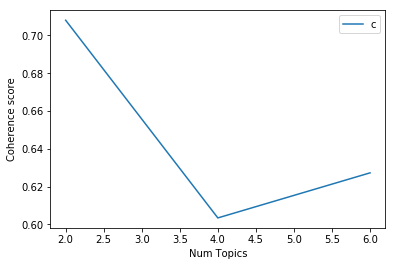

In [56]:
# Show graph with coherence results
limit=8; start=2; step=2; #'steps' is x increase in number of topics
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [57]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.708
Num Topics = 4  has Coherence Value of 0.6035
Num Topics = 6  has Coherence Value of 0.6273


In [58]:
# Selectng the most optimal model
# In this case, the second model (index 1) has the more balanced score (not too high, not too low)
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.208*"cummin" + 0.111*"swap" + 0.079*"engine" + 0.061*"diesel" + '
  '0.032*"tuner" + 0.032*"pump" + 0.032*"tranny" + 0.032*"dodge" + 0.016*"end" '
  '+ 0.016*"rolling"'),
 (1,
  '0.080*"ram" + 0.048*"part" + 0.048*"question" + 0.032*"start" + '
  '0.032*"mega" + 0.032*"advice" + 0.032*"cab" + 0.032*"manual" + '
  '0.032*"front" + 0.016*"regard"'),
 (2,
  '0.186*"gen" + 0.068*"buy" + 0.065*"truck" + 0.051*"suggestion" + '
  '0.034*"coal" + 0.034*"inch" + 0.034*"steer" + 0.017*"showcase" + '
  '0.017*"exhaust" + 0.017*"run"'),
 (3,
  '0.200*"cummin" + 0.078*"mile" + 0.078*"delete" + 0.052*"fuel" + '
  '0.047*"system" + 0.031*"egr" + 0.031*"conversion" + 0.016*"prob" + '
  '0.016*"father" + 0.016*"wiring"')]


In [59]:
# Creating a new vector to visualize the most optimal model
model2 = ldaMalletConvertToldaGen(optimal_model)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model2, corpus, id2word)
vis
pyLDAvis.save_html(vis, 'mallet_optimal_model_viz.html')

C:\Users\nepal\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\Users\nepal\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\Users\nepal\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


In [61]:
##Finding the dominant topic in each sentence
#saving topics-documents mapping list on a csv FILE
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
        # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

#save in csv file
pd.DataFrame(df_dominant_topic).to_csv('mallet_optimal_model.csv', index=False)

# Show
df_dominant_topic.head(10)

C:\Users\nepal\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.2736,"gen, buy, truck, suggestion, coal, inch, steer...",Looking at buying a second Gen Cummins what sh...
1,1,0.0,0.2703,"cummin, swap, engine, diesel, tuner, pump, tra...",Cummins swap |7.3L ---> 5.9L|
2,2,2.0,0.2818,"gen, buy, truck, suggestion, coal, inch, steer...",Tips for buying a 3rd gen mega cab
3,3,1.0,0.2596,"ram, part, question, start, mega, advice, cab,...",AEV Prospector
4,4,2.0,0.2767,"gen, buy, truck, suggestion, coal, inch, steer...",Need opinions on a truck
5,5,0.0,0.2547,"cummin, swap, engine, diesel, tuner, pump, tra...",VP44 pump gear removal
6,6,3.0,0.2904,"cummin, mile, delete, fuel, system, egr, conve...",Fuel system issues
7,7,1.0,0.2818,"ram, part, question, start, mega, advice, cab,...",2019 Cummins Tradesman remote keyless start
8,8,2.0,0.3141,"gen, buy, truck, suggestion, coal, inch, steer...",4th gen steering wheel In a 3rd gen truck.
9,9,1.0,0.2596,"ram, part, question, start, mega, advice, cab,...",DIH4 into 4bt manifold??


In [57]:
##Find the most representative document for each topic
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3644,"cummin, ram, question, coal, dodge, keyless, r...",Inherited dad's 1992 Cummins Ram. Question abo...
1,1.0,0.3629,"delete, fuel, truck, system, suggestion, inch,...",3rd Gen Cummins Fass fuel system plumbing and ...
2,2.0,0.3070,"gen, mile, engine, diesel, part, pump, convers...",Has anyone ever done a conversion from diesel ...
3,3.0,0.3125,"swap, buy, front, tranny, advice, cab, mega, c...",Looking to swap 2002 f250 5.4 triton with a 5....


In [58]:
## Topic distribution across documents
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0.0,"cummin, ram, question, coal, dodge, keyless, r...",203.0,0.4126
1,0.0,"cummin, ram, question, coal, dodge, keyless, r...",83.0,0.1687
2,3.0,"swap, buy, front, tranny, advice, cab, mega, c...",124.0,0.2520
3,0.0,"cummin, ram, question, coal, dodge, keyless, r...",82.0,0.1667
4,1.0,"delete, fuel, truck, system, suggestion, inch,...",NaN,NaN
5,1.0,"delete, fuel, truck, system, suggestion, inch,...",NaN,NaN
6,1.0,"delete, fuel, truck, system, suggestion, inch,...",NaN,NaN
7,0.0,"cummin, ram, question, coal, dodge, keyless, r...",NaN,NaN
8,2.0,"gen, mile, engine, diesel, part, pump, convers...",NaN,NaN
9,2.0,"gen, mile, engine, diesel, part, pump, convers...",NaN,NaN
